In [60]:
import ast
import networkx as nx
import matplotlib.pyplot as plt

In [61]:
with open("D:\\Nik\\Projects\\magistrska-naloga\\short-presentation\\preprocessing_example.py", "r") as source:
    ast_node = ast.parse(source.read())

print(ast.dump(ast_node, indent=2))

Module(
  body=[
    Import(
      names=[
        alias(name='math')]),
    FunctionDef(
      name='foo',
      args=arguments(
        posonlyargs=[],
        args=[
          arg(arg='bar')],
        kwonlyargs=[],
        kw_defaults=[],
        defaults=[]),
      body=[
        Assign(
          targets=[
            Name(id='baz', ctx=Store())],
          value=List(elts=[], ctx=Load())),
        For(
          target=Name(id='x', ctx=Store()),
          iter=Name(id='bar', ctx=Load()),
          body=[
            If(
              test=Compare(
                left=BinOp(
                  left=Call(
                    func=Attribute(
                      value=Name(id='math', ctx=Load()),
                      attr='sqrt',
                      ctx=Load()),
                    args=[
                      Name(id='x', ctx=Load())],
                    keywords=[]),
                  op=Mod(),
                  right=Constant(value=1)),
                ops=[
               

In [62]:
def add_ast_node_to_graph(G: nx.DiGraph, node, id=0):
    node_id = id
    G.add_node(node_id, type=node)
    # for fieldname, value in ast.iter_fields(node):
    #     G.add_node(fieldname)
    #     for child in value:
    #         add_ast_node_to_graph(G, child)
    #         G.add_edge(fieldname, child)
        # G.add_node(value)
        # G.add_edge(node, fieldname)
        # G.add_edge(fieldname, value)
    for child in ast.iter_child_nodes(node):
        id += 1
        add_ast_node_to_graph(G, child, id)
        G.add_edge(node_id, id)

In [63]:
def ast_to_graph(node, id=0, skip_nulls=False):
    """
    Return a formatted dump of the tree in node.  This is mainly useful for
    debugging purposes.  If annotate_fields is true (by default),
    the returned string will show the names and the values for fields.
    If annotate_fields is false, the result string will be more compact by
    omitting unambiguous field names.  Attributes such as line
    numbers and column offsets are not dumped by default.  If this is wanted,
    include_attributes can be set to true.  If indent is a non-negative
    integer or string, then the tree will be pretty-printed with that indent
    level. None (the default) selects the single line representation.
    """
    def _add_node_to_graph(node, id: int) -> list:
        node_id = id
        G.add_node(node_id, type=node.__class__.__name__)
        if isinstance(node, ast.AST):
            cls = type(node)
            for name in node._fields:
                try:
                    value = getattr(node, name)
                except AttributeError:
                    continue
                if value is None:
                    continue
                skippable = skip_nulls and not value
                if skippable:
                    continue
                field_id = id + 1
                G.add_node(field_id, type=name)
                G.add_edge(node_id, field_id)
                child_id = field_id + 1
                id = _add_node_to_graph(value, child_id)
                # G.nodes[child_id]["desc"] = G.nodes[child_id]["type"]
                # G.nodes[child_id]["type"] = name
                G.add_edge(field_id, child_id)
            return id
        elif isinstance(node, list):
            # G.nodes[node_id]["desc"] = "[ ]"
            for x in node:
                id += 1
                child_id = id
                id = _add_node_to_graph(x, child_id)
                G.add_edge(node_id, child_id)
            return id
        else:
            G.nodes[node_id]['desc'] = repr(node)
            return id

    if not isinstance(node, ast.AST):
        raise TypeError('expected AST, got %r' % node.__class__.__name__)
    G = nx.DiGraph()
    id = _add_node_to_graph(node, id)
    return G, id

{8: Text(27.0, 946.0, "'math'"),
 11: Text(99.0, 1162.0, "'foo'"),
 18: Text(54.0, 802.0, "'bar'"),
 26: Text(126.0, 730.0, "'baz'"),
 37: Text(342.0, 802.0, "'x'"),
 43: Text(486.0, 802.0, "'bar'"),
 60: Text(170.0, 10.0, "'math'"),
 64: Text(278.0, 154.0, "'sqrt'"),
 71: Text(422.0, 82.0, "'x'"),
 79: Text(486.0, 298.0, '1'),
 96: Text(582.0, 82.0, "'baz'"),
 100: Text(658.0, 226.0, "'append'"),
 107: Text(802.0, 154.0, "'x'"),
 114: Text(774.0, 802.0, "'baz'")}

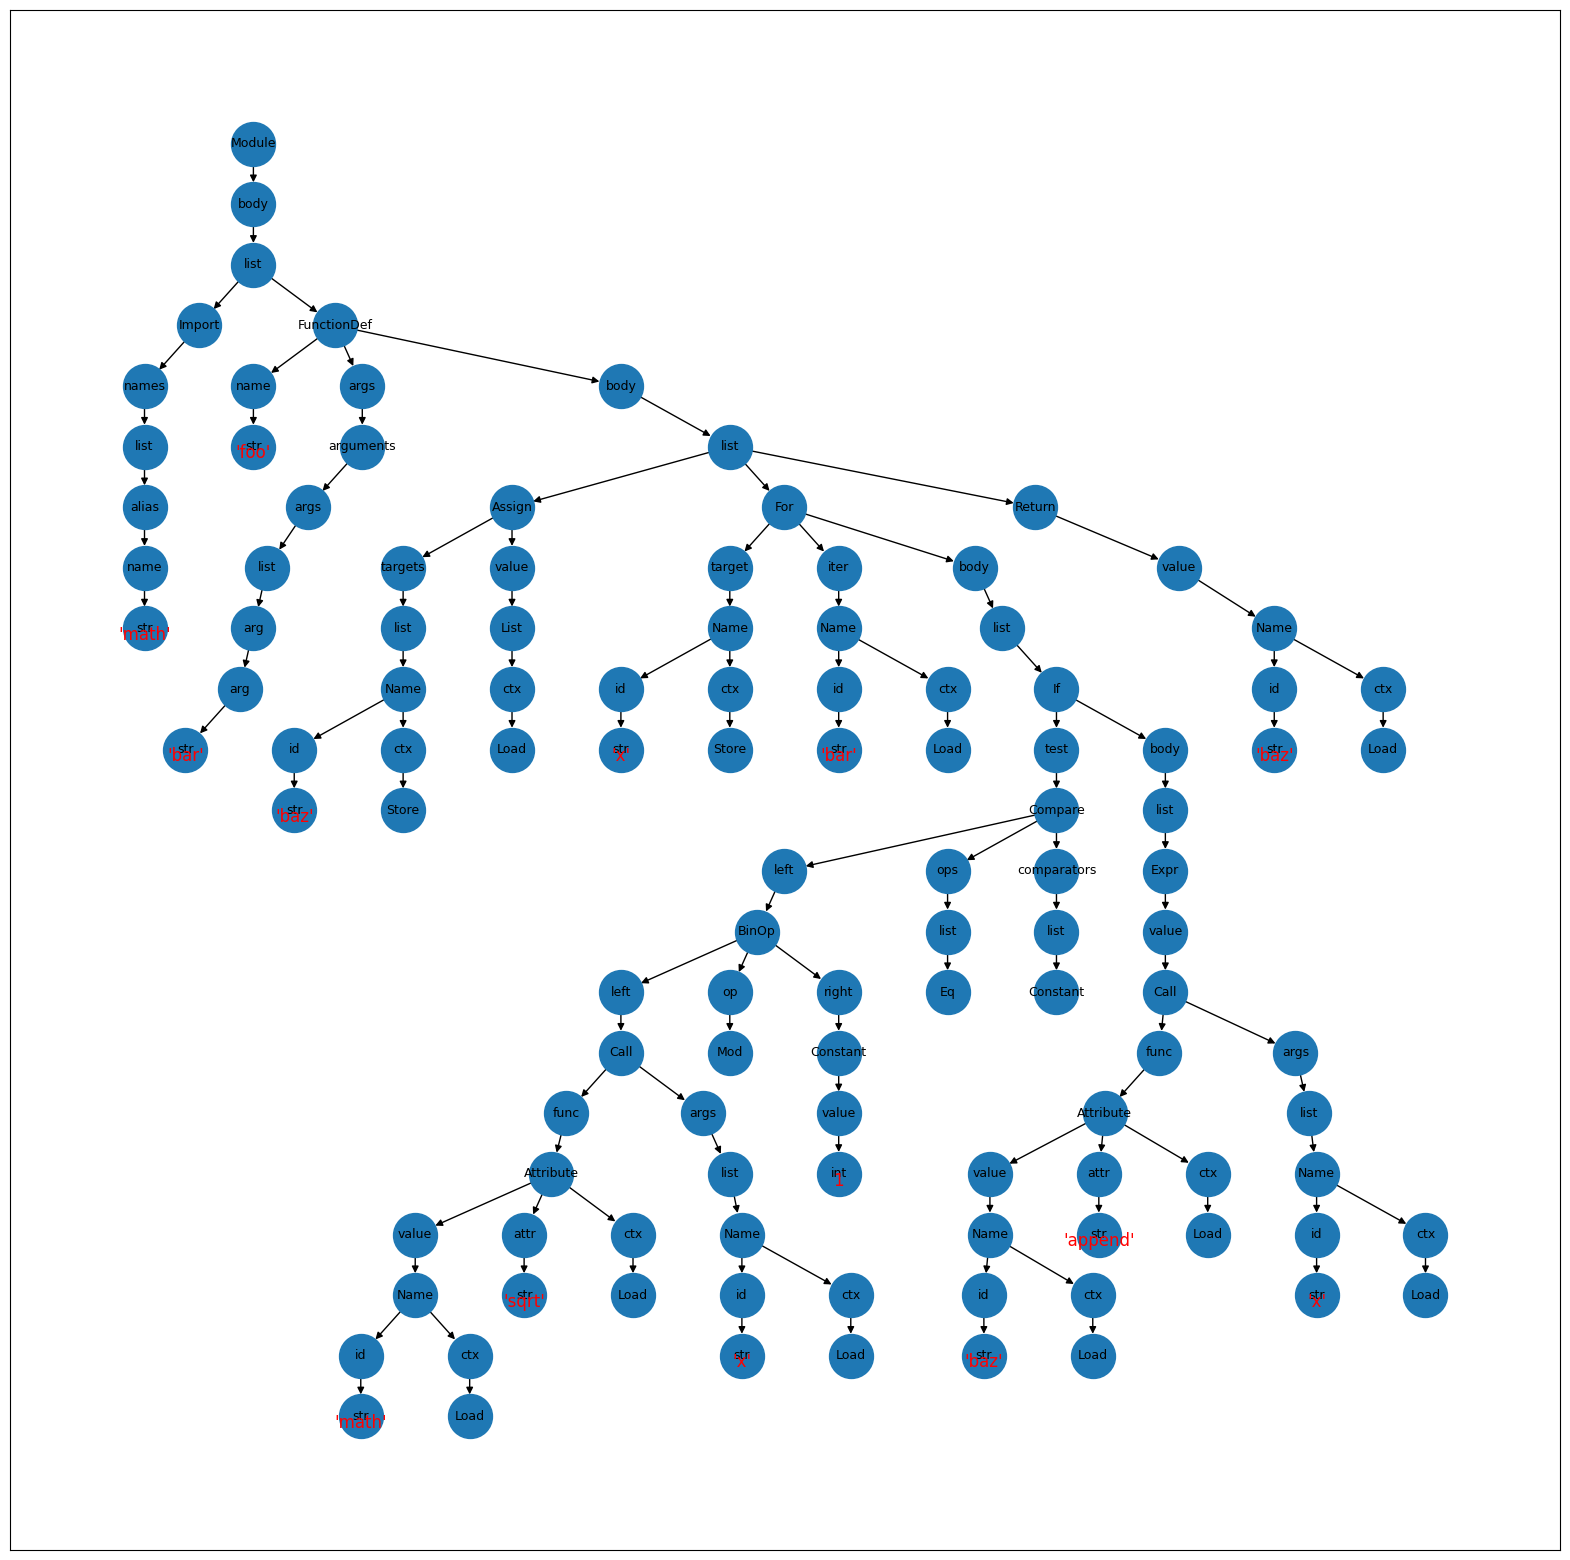

In [64]:

# G = nx.DiGraph()
# add_ast_node_to_graph(G, ast_node)
G, _ = ast_to_graph(ast_node, skip_nulls=False)
type_labels = nx.get_node_attributes(G, "type")
desc_labels = nx.get_node_attributes(G, "desc")
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
state_pos = {n: (x, y-8) for n, (x,y) in pos.items()}

plt.figure(figsize=(20, 20), dpi=100)
nx.draw_networkx(G, pos, labels=type_labels, node_size=1000, font_size=9)
nx.draw_networkx_labels(G, state_pos, labels=desc_labels, font_color='red')

